In [38]:
import xarray as xr
import dask
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import glob
import pandas as pd
import os
import cartopy.crs as ccrs
import numpy as np
import pandas as pd


def spatial_mean(da):
    """Computes the spatial mean if lat and lon dimensions are present."""
    if 'lat' in da.dims and 'lon' in da.dims:
        return da.mean(dim=['lat', 'lon'])
    return da

# Convert cftime.DatetimeNoLeap to numpy.datetime64
def convert_time(ds):
    ds['time'] = [pd.Timestamp(time.strftime()) for time in ds['time'].values]
    return ds


#  Understand land surface data
##  1.  Load the landsurface data

In [39]:
fsurdat: str = "/home/jguo/projects/cesm/inputdata/lnd/clm2/surfdata_map/release-clm5.0.18/surfdata_0.9x1.25_hist_16pfts_Irrig_CMIP6_simyr2000_c190214.nc"
# Load the dataset
ds_sur = xr.open_mfdataset(fsurdat)
ds_sur

<xarray.Dataset>
Dimensions:                  (lsmlat: 192, lsmlon: 288, nlevsoi: 10,
                              natpft: 15, cft: 2, time: 12, lsmpft: 17,
                              numurbl: 3, numrad: 2, nlevurb: 5, nglcecp1: 11,
                              nglcec: 10)
Coordinates:
  * natpft                   (natpft) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14
  * cft                      (cft) int32 15 16
  * time                     (time) int32 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: lsmlat, lsmlon, nlevsoi, lsmpft, numurbl,
                                numrad, nlevurb, nglcecp1, nglcec
Data variables: (12/81)
    mxsoil_color             int32 ...
    SOIL_COLOR               (lsmlat, lsmlon) int32 dask.array<chunksize=(192, 288), meta=np.ndarray>
    PCT_SAND                 (nlevsoi, lsmlat, lsmlon) float64 dask.array<chunksize=(10, 192, 288), meta=np.ndarray>
    PCT_CLAY                 (nlevsoi, lsmlat, lsmlon) float64 dask.array<chunksize=(10, 192, 288), meta=np.ndarray>
    ORGANIC                  (nlevsoi, lsmlat, lsmlon) float64 dask.array<chunksize=(10, 192, 288), meta=np.ndarray>
    FMAX                     (lsmlat, lsmlon) float64 dask.array<chunksize=(192, 288), meta=np.ndarray>
    ...                       ...
    CONST_HARVEST_SH2        (lsmlat, lsmlon) float64 dask.array<chunksize=(192, 288), meta=np.ndarray>
    CONST_HARVEST_SH3        (lsmlat, lsmlon) float64 dask.array<chunksize=(192, 288), meta=np.ndarray>
    CONST_GRAZING            (lsmlat, lsmlon) float64 dask.array<chunksize=(192, 288), meta=np.ndarray>
    CONST_FERTNITRO_CFT      (cft, lsmlat, lsmlon) float64 dask.array<chunksize=(2, 192, 288), meta=np.ndarray>
    UNREPRESENTED_PFT_LULCC  (natpft, lsmlat, lsmlon) float64 dask.array<chunksize=(15, 192, 288), meta=np.ndarray>
    UNREPRESENTED_CFT_LULCC  (cft, lsmlat, lsmlon) float64 dask.array<chunksize=(2, 192, 288), meta=np.ndarray>
Attributes: (12/50)
    Conventions:                          NCAR-CSM
    History_Log:                          created on: 02-14-19 10:18:19
    Logname:                              erik
    Host:                                 cheyenne3
    Source:                               Community Land Model: CLM5
    Version:                              release-clm5.0.18/gpfs/fs1/scratch/...
    ...                                   ...
    map_vic_file:                         map_0.9x1.25_GRDC_to_0.9x1.25_nomas...
    Soil_texture_raw_data_file_name:      mksrf_soitex.10level.c010119.nc
    Soil_color_raw_data_file_name:        mksrf_soilcolor_CMIP6_simyr2005.c17...
    Fmax_raw_data_file_name:              mksrf_fmax_3x3min_USGS_c120911.nc
    Organic_matter_raw_data_file_name:    mksrf_organic_10level_5x5min_ISRIC-...
    Vegetation_type_raw_data_filename:    mksrf_landuse_histclm50_LUH2_2000.c...

##  2. Assign coordinate value to be actual lat and lon degree not the index

In [40]:
# Extract a column of unique latitudes and a row of unique longitudes as raw arrays
# convert to float32 to match the hw temperature data later. this gave me a lot of trouble
unique_lats = ds_sur['LATIXY'].isel(lsmlon=0).data.astype('float32')  # Extracting the raw array for latitudes
unique_lons = ds_sur['LONGXY'].isel(lsmlat=0).data.astype('float32')  # Extracting the raw array for longitudes

# Assign these raw arrays as new coordinates (without specifying old dimensions)
ds_sur = ds_sur.assign_coords(lat=('lsmlat', unique_lats), lon=('lsmlon', unique_lons))

# Swap 'lsmlat' and 'lsmlon' dimensions with 'lat' and 'lon'
ds_sur = ds_sur.swap_dims({'lsmlat': 'lat', 'lsmlon': 'lon'})

# Drop the original 'lsmlat' and 'lsmlon' dimensions if they are no longer needed
ds_sur = ds_sur.drop_vars(['lsmlat', 'lsmlon'], errors='ignore')



# Now, your DataArray or any variable extracted from ds_sur should have 1 dimensionional (1D) lat and lon coordinates
total_urban_pct = ds_sur['PCT_URBAN']  # Example variable
print(total_urban_pct)

# At this point, the dataset dimensions will be based on actual latitude and longitude values


<xarray.DataArray 'PCT_URBAN' (numurbl: 3, lat: 192, lon: 288)>
dask.array<open_dataset-PCT_URBAN, shape=(3, 192, 288), dtype=float64, chunksize=(3, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Dimensions without coordinates: numurbl
Attributes:
    long_name:  percent urban for each density type
    units:      unitless



##  3.  Determine which grid is Urban

In [41]:
# Access the PCT_URBAN variable
pct_urban = ds_sur['PCT_URBAN']
pct_urban


<xarray.DataArray 'PCT_URBAN' (numurbl: 3, lat: 192, lon: 288)>
dask.array<open_dataset-PCT_URBAN, shape=(3, 192, 288), dtype=float64, chunksize=(3, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Dimensions without coordinates: numurbl
Attributes:
    long_name:  percent urban for each density type
    units:      unitless

In [42]:
# Sum across the 'numurbl' dimension to get total urban coverage

# https://bb.cgd.ucar.edu/cesm/threads/proportion-of-cities-in-surface-data.8046/
# PCT_URBAN is the percent of each urban density type. The density types in order are
# tall building district (TBD), high density (HD), and medium density (MD).
# If you change those percentages, e.g, increase them, then you'll need to decrease
# some other surface type (e.g., PCT_NATVEG, PCT_CROP, PCT_LAKE, etc.).
# The sum of PCT_URBAN, PCT_NATVEG, PCT_CROP, PCT_LAKE, PCT_GLACIER, PCT_WETLAND needs to be 100%.
# PCT_URBAN has multiple layers for different urban density types, sum across the 'numurbl' dimension to get total urban coverage
total_urban_pct = pct_urban.sum(dim='numurbl')
print(total_urban_pct)
total_urban_pct

<xarray.DataArray 'PCT_URBAN' (lat: 192, lon: 288)>
dask.array<sum-aggregate, shape=(192, 288), dtype=float64, chunksize=(192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8


<xarray.DataArray 'PCT_URBAN' (lat: 192, lon: 288)>
dask.array<sum-aggregate, shape=(192, 288), dtype=float64, chunksize=(192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8


##  4.  Create a mask for the urban grid, the mask is variable masked_urban_areas

In [43]:
# Use .where() to assign 1 to urban cells (where total urban percentage > 2%) and NaN to others
urban_grid_mask = total_urban_pct.where(total_urban_pct > 2, other=np.nan)

# Now, replace all non-NaN values (which indicate urban areas) with 1
# This is done by utilizing the np.where function from the numpy library to replace non-NaN (i.e., urban) values with 1
urban_grid_binary = xr.where(urban_grid_mask.notnull(), 1, urban_grid_mask)



def find_top_urban_areas(masked_urban_areas):
    # Convert the stacked DataArray to a pandas DataFrame
    df = masked_urban_areas.stack(z=('lat', 'lon')).to_dataframe(name='urban_pct')

    # Use the nlargest method on the DataFrame to find the top 50 values
    top_urban_areas_df = df.nlargest(50, 'urban_pct')
    # Drop the redundant 'lsmlat' and 'lsmlon' columns
    top_urban_areas_df = top_urban_areas_df.drop(columns=['lat', 'lon'])

    return top_urban_areas_df


# Call the function with the masked_urban_areas variable
top_urban_areas = find_top_urban_areas(urban_grid_mask)
print(top_urban_areas)

print( "percentage grid cells are urban:", urban_grid_mask.count().compute().item() * 100 / (192 * 288), "%")

# Rename dimensions in urban_grid_binary to match those in HW
# urban_grid_binary = urban_grid_binary.rename({'lsmlat': 'lat', 'lsmlon': 'lon'})
urban_grid_binary


                   urban_pct
lat        lon              
 37.225132 2.50    55.611619
 8.010471  78.75   50.000000
 34.397907 35.00   48.645890
-34.397907 26.25   41.867101
-35.340313 303.75  40.578987
-5.183246  11.25   36.724269
 35.340313 140.00  35.587411
 41.937172 31.25   35.364088
 30.628273 31.25   34.218028
 8.010471  72.50   34.168117
 40.994766 2.50    33.720860
 34.397907 352.50  33.393325
 10.837696 73.75   33.333333
 41.937172 272.50  33.317939
 19.319372 72.50   32.948605
-0.471204  278.75  30.613177
 52.303665 3.75    30.387382
 51.361256 0.00    29.279365
 33.455498 241.25  28.873214
 50.418850 0.00    27.881184
 12.722513 278.75  26.663272
 31.570681 30.00   26.502659
 28.743456 77.50   25.918830
-6.125654  106.25  25.912425
 23.089005 88.75   24.923125
 51.361256 7.50    24.385361
 32.513088 242.50  23.855810
 34.397907 135.00  23.472601
-6.125654  107.50  23.454897
 25.916231 280.00  23.350594
-23.089005 316.25  22.688645
 5.183246  0.00    22.512972
 50.418850 358

<xarray.DataArray 'PCT_URBAN' (lat: 192, lon: 288)>
dask.array<where, shape=(192, 288), dtype=float64, chunksize=(192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8


##  5.  Plot the urban grid

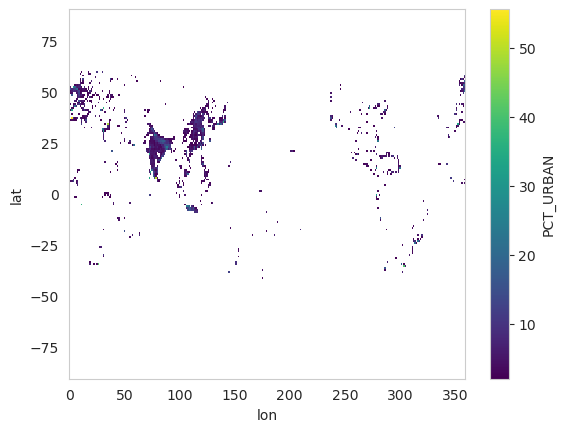

In [44]:
urban_grid_mask.plot()

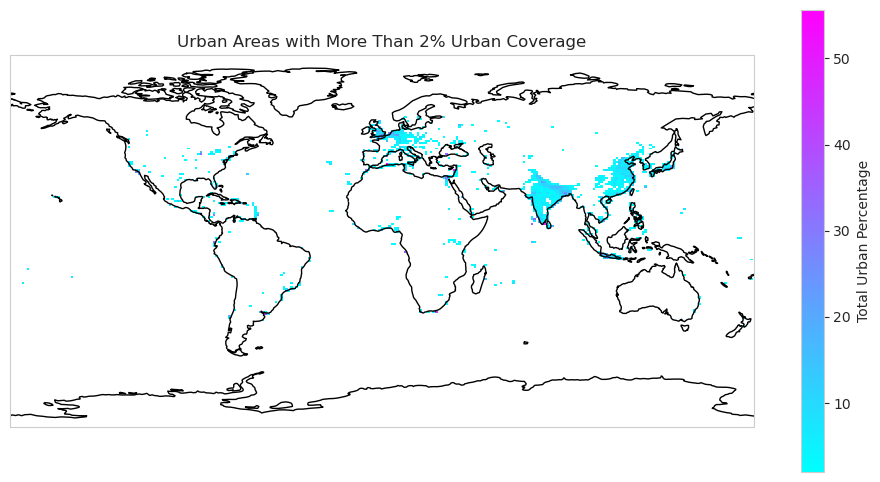

In [45]:
# Plotting
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

# Get longitude and latitude information from the dataset
longitude = ds_sur['LONGXY']
latitude = ds_sur['LATIXY']

# Plotting the urban areas that meet the condition
# Note: urban_grid_mask already has values below 2% filtered out, so we use it directly
plt.pcolormesh(longitude, latitude, urban_grid_mask, transform=ccrs.PlateCarree(), cmap='cool') #cmap='cool') cmap='Reds')

plt.colorbar(label='Total Urban Percentage')
plt.title('Urban Areas with More Than 2% Urban Coverage')
plt.show()


#  Define HW Temporal filter
##  1.  Load the daily(h1 tape) simulation temperature data

Load the dataset, I copied the daily h1 files to /home/jguo/process_data/i.e215.I2000Clm50SpGs.hw_production.02/daily_raw it is 137G in total
I run the utils/extract_var_save.py to extract the subset of variables from the above directory
and save the data to /home/jguo/process_data/i.e215.I2000Clm50SpGs.hw_production.02/summary

In [46]:
hw_summary_dir = '/home/jguo/process_data/i.e215.I2000Clm50SpGs.hw_production.02/summary'
hw_output_file = 'i.e215.I2000Clm50SpGs.hw_production.02.clm2.h1.hw.nc'
hw_out_file_path = os.path.join(hw_summary_dir, hw_output_file)
#check if hw_file exists
hw_file_exist = os.path.isfile(hw_out_file_path)


##  2   For each grid cell the find time periods that satisfy the HW definition. 

We use the definition from the US National Weather Service (NWS): three or more consecutive days of maximumtemperature reaching at least 90 ◦F (32.2 ◦C). 
We consider that, in each grid cell (a size on the order of 100 × 100 km), its rural sub-grid represents a local background environment for the city. 
Therefore, for each city we use its rural 2m-height temperature (T2m,rural) to define HWs.

We use this variable in the daily h1 file: TREFMXAV_R:long_name = "Rural daily maximum of average 2-m temperature" ;

In [47]:

#if hw_file does not exist, then we need to run the following code to create the hw_file
if not hw_file_exist:
    # Open the NetCDF file containing the rural daily maximum of average 2-m temperature
    hw_input_file = 'i.e215.I2000Clm50SpGs.hw_production.02.clm2.h1.TSA_UR_TREFMXAV_R.nc'
    hw_input_file_path = os.path.join(hw_summary_dir, hw_input_file)
    ds_hw = xr.open_dataset(hw_input_file_path)
    ds_hw
    # Define the threshold temperature in Kelvin
    # Convert 90 degrees Fahrenheit to Kelvin
    fahrenheit_threshold = 90
    kelvin_threshold = (fahrenheit_threshold - 32) * (5/9) + 273.15

    # Define a function to apply on each grid cell to detect heatwaves
    def detect_heatwave(tsa_r_np):
        # Ensure tsa_r_np is a 1D array for simplicity
        tsa_r_np = np.atleast_1d(tsa_r_np)
        hw = np.full(tsa_r_np.shape, np.nan)  # Initialize HW with NaN

        # Check for heatwaves
        for i in range(2, len(tsa_r_np)):
            if (tsa_r_np[i-2] > kelvin_threshold and
                    tsa_r_np[i-1] > kelvin_threshold and
                    tsa_r_np[i] > kelvin_threshold):
                hw[i-2:i+1] = 1  # Mark all three days as heatwave

        return hw

    # Use apply_ufunc to apply the detect_heatwave function across the dataset
    hw = xr.apply_ufunc(
        detect_heatwave, ds_hw['TSA_R'],
        input_core_dims=[['time']],  # Specify the core dimension
        output_core_dims=[['time']],  # Ensure output has the same core dimension as input
        vectorize=True,  # Enable broadcasting and looping over other dimensions
        output_dtypes=[float]  # Specify the output data type
    )
    # Optional: save the modified dataset to a new NetCDF file
    # Assign the HW data back to the original dataset as a new variable
    ds_hw['HW'] = hw
    # ds_hw.to_netcdf('hw_file_path')   
else:
    # Load the existing HW data
    ds_hw =xr.open_dataset(hw_out_file_path)
    hw = ds_hw['HW']    

print(hw)
hw


<xarray.DataArray 'HW' (lat: 192, lon: 288, time: 10951)>
[605546496 values with dtype=float64]
Coordinates:
  * time     (time) object 1985-01-01 00:00:00 ... 2015-01-01 00:00:00
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0


<xarray.DataArray 'HW' (lat: 192, lon: 288, time: 10951)>
[605546496 values with dtype=float64]
Coordinates:
  * time     (time) object 1985-01-01 00:00:00 ... 2015-01-01 00:00:00
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0


##  3.  The outcome should be 2D array with 1 for HW day and 0 for non HW day, the xarray should daily time dimension.

In [48]:
#todo read hw from the output file hw_file_path
hw

<xarray.DataArray 'HW' (lat: 192, lon: 288, time: 10951)>
[605546496 values with dtype=float64]
Coordinates:
  * time     (time) object 1985-01-01 00:00:00 ... 2015-01-01 00:00:00
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0


##  4.  Interecting the HW grid with the Urban grid, we can find the HW days for each urban grid

In [49]:


print(hw.lon.equals(urban_grid_binary.lon))
print(hw.lat.equals(urban_grid_binary.lat))

print(type(urban_grid_binary.lon))
print(type(hw.lon))
print('\nurban_grid_binary.lon:\n', urban_grid_binary.lon, '\n')
print("hw.lon:\n", hw.lon, '\n')

True
True
<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>

urban_grid_binary.lon:
 <xarray.DataArray 'lon' (lon: 288)>
array([  0.  ,   1.25,   2.5 , ..., 356.25, 357.5 , 358.75], dtype=float32)
Coordinates:
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8 

hw.lon:
 <xarray.DataArray 'lon' (lon: 288)>
array([  0.  ,   1.25,   2.5 , ..., 356.25, 357.5 , 358.75], dtype=float32)
Coordinates:
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Attributes:
    long_name:  coordinate longitude
    units:      degrees_east 


In [55]:
# check in hw, how many grid cells has hw == 1 on the first day
hw.isel(time=0).where(hw.isel(time=0) == 1, drop=True)
#add total number of grid cells that has hw == 1
hw.isel(time=0).where(hw.isel(time=0) == 1, drop=True).count().compute().item()

80

In [51]:
# Intersect the HW data with the urban grid
hw_urban = xr.where(urban_grid_binary == 1, hw, np.nan)

hw_urban

<xarray.DataArray (lat: 192, lon: 288, time: 10951)>
dask.array<where, shape=(192, 288, 10951), dtype=float64, chunksize=(192, 288, 10951), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 1985-01-01 00:00:00 ... 2015-01-01 00:00:00

In [52]:
# Compute the slice for the first time point if hw_urban is a Dask-backed array
hw_urban_time_0_computed = hw_urban.isel(time=517).compute()

# Now apply the where operation on the computed DataArray
hw_urban_hw_cells = hw_urban_time_0_computed.where(hw_urban_time_0_computed == 1, drop=True)

# Count the number of grid cells with HW == 1
hw_urban_hw_count = hw_urban_hw_cells.count().item()

print(hw_urban_hw_count)


142


In [53]:
# Mask the hw_urban dataset to only include cells with HW == 1
hw_urban_masked = hw_urban.where(hw_urban == 1)

# Sum over the spatial dimensions to count the number of HW == 1 cells for each day
# Assuming 'lat' and 'lon' are the names of your spatial dimensions
daily_hw_urban_count = hw_urban.sum(dim=['lat', 'lon'])

# Compute the result if using Dask
daily_hw_urban_count_computed = daily_hw_urban_count.compute()

# daily_hw_urban_count_computed now contains the daily count of urban grid cells with HW == 1
print(daily_hw_urban_count_computed)

#print out daily count of urban grid cells for days that has count > 1
hw_dates= daily_hw_urban_count_computed.where(daily_hw_urban_count_computed > 1, drop=True)


<xarray.DataArray (time: 10951)>
array([0., 0., 0., ..., 0., 0., 0.])
Coordinates:
  * time     (time) object 1985-01-01 00:00:00 ... 2015-01-01 00:00:00


In [54]:
hw_dates
#save hw_dates to a file
hw_dates.to_netcdf('/home/jguo/process_data/i.e215.I2000Clm50SpGs.hw_production.02/summary/hw_dates.nc')   

In [24]:
hw_urban.isel(time=0).where(hw_urban.isel(time=0) == 1, drop=True).count().compute().item()

KeyError: 'Indexing with a boolean dask array is not allowed. This will result in a dask array of unknown shape. Such arrays are unsupported by Xarray.Please compute the indexer first using .compute()'

In [21]:
# Step 1: Mask the hw dataset to only include grid cells marked as urban in urban_grid_binary
hw_urban = hw.where(urban_grid_binary == 1)

# Step 2: Reduce the hw_urban dataset along spatial dimensions to identify any heatwave occurrence in urban areas for each date
# The reduction will result in a DataArray where each time point has a value of True if any urban grid cell experienced a heatwave, and False otherwise
hw_urban_any = hw_urban.reduce(np.any, dim=['lat', 'lon'])
# Ensure hw_urban_any is computed if it's a Dask array and convert time to a pandas Timestamp
hw_urban_any_computed = hw_urban_any.compute()

In [20]:

# Step 3: Filter the time coordinate where there's at least one urban heatwave, which gives us the dates we're interested in
hw_dates = hw_urban_any_computed.time.where(hw_urban_any_computed, drop=True)

# Convert the hw_dates xarray DataArray to a list of pandas Timestamps for easier interpretation and use
hw_dates_list = pd.to_datetime(hw_dates.values).tolist()

# Print the resulting list of dates
print(hw_dates_list)




TypeError: <class 'cftime._cftime.DatetimeNoLeap'> is not convertible to datetime, at position 0

In [15]:
print(hw_urban)
hw_urban.isel(time=0).drop(['time'])

<xarray.DataArray (lat: 192, lon: 288, time: 10951)>
dask.array<where, shape=(192, 288, 10951), dtype=float64, chunksize=(192, 288, 10951), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 1985-01-01 00:00:00 ... 2015-01-01 00:00:00


<xarray.DataArray (lat: 192, lon: 288)>
dask.array<getitem, shape=(192, 288), dtype=float64, chunksize=(192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8


###  4.1 make sure we do north and south hemisphere correctly
##  5. Compute the "HW days for Any grid" list of dates. I need to load file on that day if any grid has a HW day.  

In [16]:
# Check when HW == 1 for any grid cell and reduce the data array to a 1D time series
heatwave_days = hw_urban.any(dim=('lat', 'lon')).compute() #reduce the data array to a 1D time series

# Extract the dates where the condition is True
heatwave_dates = hw_urban['time'].where(heatwave_days, drop=True)

# Print the dates
print(heatwave_dates.values)

[cftime.DatetimeNoLeap(1985, 1, 1, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1985, 1, 2, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1985, 1, 3, 0, 0, 0, 0, has_year_zero=True) ...
 cftime.DatetimeNoLeap(2014, 12, 30, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2014, 12, 31, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2015, 1, 1, 0, 0, 0, 0, has_year_zero=True)]


In [ ]:
# Count the number of HW days
num_hw_days = heatwave_dates.size

print("Number of Heatwave Days:", num_hw_days)


###  5.1  further descrease that list by 


#  Process hourly simulation output data
##  1. Load the hourly simulation temperature data from "HW days for Any grid" list of dates
##  2. Convert UTC to local time 
##  3. Compute the UHI for 2m air T for each HW grid
##  4. Compute the UWBI for surface for each HW grid

#  Analyzing outcomes, figuring out what are the factors that is driving the UHI and UWBI
##  1.  feature engineering, the right hand side factors
###  1.1  humidity(precipitation))
###  1.2  distance to shore (what about big lakes)?
###  1.3  Different part of day (morning, afternoon, evening, night)
###  1.4  Surface roughness, albedo, vegetation

